# IMPORTA BIBLIOTECAS

In [1]:
# MANIPULAÇÃO DE DADOS
import pandas as pd
import numpy as np
from datetime import datetime

# VISUALIZAÇÃO DE DADOS
import matplotlib.pyplot as plt

# TRANSFORMAÇÕES
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from imblearn import over_sampling, under_sampling


# PREPARAÇÃO TREINO E AVALIAÇÃO
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# MODELOS UTILIZADOS
from mixed_naive_bayes import MixedNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# CONFIGURAÇÕES DE EXIBIÇÃO
import warnings

warnings.filterwarnings("ignore")

# pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# IMPORTAÇÃO DE DADOS

In [2]:
weather_aus = pd.read_csv("../DATA/weatherAUS.csv").dropna()

print(
    f"O dataset possui {weather_aus.shape[0]:,} instâncias (linhas) e {weather_aus.shape[1]:,} características (colunas)."
)

print(f"As características (colunas) do dataset são: {weather_aus.columns.to_list()}")

O dataset possui 56,420 instâncias (linhas) e 23 características (colunas).
As características (colunas) do dataset são: ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


# FUNÇÕES PARA PRÉ-PROCESSAMENTO


In [3]:
def split_data(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Dividir a base em treino e teste, mantendo a proporção das classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    return df_train, df_test

In [4]:
def adjust_data_types(df):
    df.RainTomorrow = df.RainTomorrow.map({"Yes": 1, "No": 0})

    return df


In [5]:
def create_auxiliar_columns(df):
    # COLUNAS SELECIONADAS COM BASE NAS AVALIAÇÕES ANTERIORES
    df = df[
        [
            "MinTemp",
            "MaxTemp",
            "Rainfall",
            "Evaporation",
            "Sunshine",
            "WindGustSpeed",
            "WindSpeed9am",
            "WindSpeed3pm",
            "Humidity9am",
            "Humidity3pm",
            "Pressure3pm",
            "Cloud9am",
            "Cloud3pm",
            "RainTomorrow",
            "WindGustDir",
            "WindDir3pm",
        ]
    ]

    df["RangeTemp"] = df["MaxTemp"] - df["MinTemp"]

    # SEPARA AS VARIÁVEIS CATEGÓRICAS E NUMÉRICAS
    # CATEGORIZA AS VARIÁVEIS NECESSÁRIAS
    categorical_columns = pd.get_dummies(
        df.select_dtypes(include=["object", "datetime64"]),
        columns=["WindGustDir", "WindDir3pm"],
        drop_first=True,
        prefix=["WindGustDir", "WindDir3pm"],
        dtype=int,
    )

    numerical_columns = df.select_dtypes(include=["int64", "float64"])

    df = pd.concat([numerical_columns, categorical_columns], axis=1)

    return df


In [6]:
def instance_transformations(n_components=5):
    discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans", random_state=42)
    smote = under_sampling.RandomUnderSampler(random_state=42)

    scaler = StandardScaler()
    pca = PCA(n_components=n_components, random_state=42)

    return discretizer, scaler, pca, smote

In [7]:
def adjust_train_volume(df, target_column, smote):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_res, y_res = smote.fit_resample(X, y)
    df_smote = pd.concat([X_res, y_res], axis=1)

    return df_smote

In [8]:
def fit_transformmations(df, cols, discretizer, scaler, pca, discrete_col="Rainfall"):
    discretizer.fit(df[discrete_col].values.reshape(-1, 1))

    scaler.fit(df[cols])
    pca.fit(df[cols])

    return discretizer, scaler, pca


In [9]:
def transform_data(df, cols, discretizer, scaler, pca, discrete_col="Rainfall"):
    df[discrete_col + "_Discretized"] = discretizer.transform(
        df[discrete_col].values.reshape(-1, 1)
    )
    df[cols] = scaler.transform(df[cols])
    df = df.reset_index(drop=True)

    pca_result = pca.transform(df[cols])

    df_pca = pd.DataFrame(
        data=pca_result,
        columns=[f"PC{comp}" for comp in range(1, pca.n_components_ + 1)],
    )
    df_pca = df_pca.reset_index(drop=True)
    df_pca["RainTomorrow"] = df["RainTomorrow"]

    return df, df_pca

# INICIO PRÉ-PROCESSAMENTO

SEPARA EM TREINO E TESTE

In [10]:
df_train, df_test = split_data(weather_aus, "RainTomorrow")

## PRÉ-PROCESSAMENTO NA BASE DE TREINO

AJUSTA TIPOS DE DADOS NO TREINO

In [11]:
df_train = adjust_data_types(df_train)

CRIA VARIÁVEIS AUXILIARES

In [12]:
df_train = create_auxiliar_columns(df_train)

CRIA AS INSTÂNCIAS DAS TRANSFORMAÇÕES

In [13]:
discretizer, scaler, pca, smote = instance_transformations()

AJUSTA O VOLUME DE TREINO

In [14]:
(
    df_train.RainTomorrow.value_counts(dropna=False),
    df_train.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 0    35194
 1     9942
 Name: count, dtype: int64,
 RainTomorrow
 0    0.779732
 1    0.220268
 Name: proportion, dtype: float64)

In [15]:
df_train = adjust_train_volume(df_train, "RainTomorrow", smote)

In [16]:
(
    df_train.RainTomorrow.value_counts(dropna=False),
    df_train.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 0    9942
 1    9942
 Name: count, dtype: int64,
 RainTomorrow
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

TREINA AS TRANSFORMAÇÕES COM A BASE DE TREINO

In [17]:
continuous_columns = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed9am",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
]

categorical_columns = [
    "WindGustDir_ENE",
    "WindGustDir_ESE",
    "WindGustDir_N",
    "WindGustDir_NE",
    "WindGustDir_NNE",
    "WindGustDir_NNW",
    "WindGustDir_NW",
    "WindGustDir_S",
    "WindGustDir_SE",
    "WindGustDir_SSE",
    "WindGustDir_SSW",
    "WindGustDir_SW",
    "WindGustDir_W",
    "WindGustDir_WNW",
    "WindGustDir_WSW",
    "WindDir3pm_ENE",
    "WindDir3pm_ESE",
    "WindDir3pm_N",
    "WindDir3pm_NE",
    "WindDir3pm_NNE",
    "WindDir3pm_NNW",
    "WindDir3pm_NW",
    "WindDir3pm_S",
    "WindDir3pm_SE",
    "WindDir3pm_SSE",
    "WindDir3pm_SSW",
    "WindDir3pm_SW",
    "WindDir3pm_W",
    "WindDir3pm_WNW",
    "WindDir3pm_WSW",
    "Rainfall_Discretized",
]

discretizer, scaler, pca = fit_transformmations(
    df_train, continuous_columns, discretizer, scaler, pca
)

APLICA AS TRANSFORMAÇÕES NA BASE DE TREINO

In [18]:
df_train, df_train_pca = transform_data(
    df_train, continuous_columns, discretizer, scaler, pca
)

## APLICAÇÕES SOBRE BASE DE TESTE

AJUSTA OS TIPOS DE DADOS

In [19]:
df_test = adjust_data_types(df_test)

CRIA AS COLUNAS AUXILIARES

In [20]:
df_test = create_auxiliar_columns(df_test)

APLICA AS TRANSFORMAÇÕES JÁ TREINADAS

In [21]:
df_test, df_test_pca = transform_data(
    df_test, continuous_columns, discretizer, scaler, pca
)

In [22]:
(
    df_test.RainTomorrow.value_counts(dropna=False),
    df_test.RainTomorrow.value_counts(normalize=True, dropna=False),
)

(RainTomorrow
 0    8799
 1    2485
 Name: count, dtype: int64,
 RainTomorrow
 0    0.779777
 1    0.220223
 Name: proportion, dtype: float64)

# PROCESSO DE MODELAGEM

FUNÇÃO DE APLICAÇÃO DE MODELOS

In [23]:
def run_cross_validation(
    train_data, train_target, test_data, test_target, model, param_grid, k_folds=10
):
    skf = StratifiedKFold(n_splits=k_folds)
    scores_validation = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    scores_test = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    best_params = None
    best_model = None
    best_f1 = 0
    counter = 1
    print(f"====> INICIANDO PROCESSAMENTO: {datetime.now()} <====")

    for train_index, valid_index in skf.split(train_data, train_target):
        inicio = datetime.now()
        print(f"====> {inicio} | EXECUTANDO FOLD {counter} ")
        
        # Use .iloc to select rows based on indices
        X_train_fold, X_valid_fold = (
            train_data.iloc[train_index],
            train_data.iloc[valid_index],
        )
        y_train_fold, y_valid_fold = (
            train_target.iloc[train_index],
            train_target.iloc[valid_index],
        )

        # Etapa 2: Treinamento e ajuste de hiperparâmetros com validação cruzada interna
        grid_search = GridSearchCV(
            model, param_grid, scoring="f1", cv=StratifiedKFold(n_splits=3), n_jobs=-1, verbose=3
        )
        grid_search.fit(X_train_fold, y_train_fold)
        model = grid_search.best_estimator_
        f1 = grid_search.best_score_

        if f1 > best_f1:
            best_model = model
            best_params = grid_search.best_params_
            best_f1 = f1

        # Avaliação nos dados de validação
        y_valid_pred = model.predict(X_valid_fold)

        # Cálculo das métricas no fold
        scores_validation["f1"].append(
            f1_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["accuracy"].append(accuracy_score(y_valid_fold, y_valid_pred))
        scores_validation["precision"].append(
            precision_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["recall"].append(
            recall_score(y_valid_fold, y_valid_pred, average="macro")
        )

        # Avaliar na base de teste com o melhor modelo
        y_test_pred = model.predict(test_data)
        f1_test = f1_score(test_target, y_test_pred, average="macro")
        accuracy_test = accuracy_score(test_target, y_test_pred)
        precision_test = precision_score(test_target, y_test_pred, average="macro")
        recall_test = recall_score(test_target, y_test_pred, average="macro")

        # Armazenar as métricas na base de teste
        scores_test["f1"].append(f1_test)
        scores_test["accuracy"].append(accuracy_test)
        scores_test["precision"].append(precision_test)
        scores_test["recall"].append(recall_test)
        
        counter += 1
        final = datetime.now()
        print(f"===> {final} | FINALIZADO FOLD {counter - 1} | TEMPO TOTAL {final - inicio}\n")

    # Calcula as médias das métricas nos folds de validação
    avg_scores_validation = {
        metric: np.mean(values) for metric, values in scores_validation.items()
    }
    test_scores = {metric: np.mean(values) for metric, values in scores_test.items()}

    # Criar log dos resultados
    log = pd.DataFrame(scores_validation)
    log["dataset"] = "Validação Cruzada"

    test_log = pd.DataFrame(scores_test)
    test_log["dataset"] = "Teste"

    # Concatenar os logs da validação cruzada e do teste
    full_log = pd.concat([log, test_log])

    return avg_scores_validation, test_scores, best_params, full_log

In [25]:
def run_cross_validation_svm(
    train_data, train_target, test_data, test_target, model, param_grid, k_folds=10, n_iter=20
):
    skf = StratifiedKFold(n_splits=k_folds)
    scores_validation = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    scores_test = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    best_params = None
    best_model = None
    best_f1 = 0
    counter = 1
    print("====> INICIANDO PROCESSAMENTO <====")

    for train_index, valid_index in skf.split(train_data, train_target):
        inicio = datetime.now()
        print(f"====> {inicio} | EXECUTANDO FOLD {counter} ")
        
        # Selecionar folds
        X_train_fold, X_valid_fold = (
            train_data.iloc[train_index],
            train_data.iloc[valid_index],
        )
        y_train_fold, y_valid_fold = (
            train_target.iloc[train_index],
            train_target.iloc[valid_index],
        )

        # Utilizar RandomizedSearchCV para uma busca mais rápida de hiperparâmetros
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grid, n_iter=n_iter, scoring="f1_macro", cv=3, random_state=42, n_jobs=-1, verbose=3
        )
        random_search.fit(X_train_fold, y_train_fold)
        model = random_search.best_estimator_
        f1 = random_search.best_score_

        if f1 > best_f1:
            best_model = model
            best_params = random_search.best_params_
            best_f1 = f1

        # Avaliação nos dados de validação
        y_valid_pred = model.predict(X_valid_fold)

        # Cálculo das métricas no fold
        scores_validation["f1"].append(
            f1_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["accuracy"].append(accuracy_score(y_valid_fold, y_valid_pred))
        scores_validation["precision"].append(
            precision_score(y_valid_fold, y_valid_pred, average="macro")
        )
        scores_validation["recall"].append(
            recall_score(y_valid_fold, y_valid_pred, average="macro")
        )

        # Avaliar na base de teste com o melhor modelo
        y_test_pred = model.predict(test_data)
        f1_test = f1_score(test_target, y_test_pred, average="macro")
        accuracy_test = accuracy_score(test_target, y_test_pred)
        precision_test = precision_score(test_target, y_test_pred, average="macro")
        recall_test = recall_score(test_target, y_test_pred, average="macro")

        # Armazenar as métricas na base de teste
        scores_test["f1"].append(f1_test)
        scores_test["accuracy"].append(accuracy_test)
        scores_test["precision"].append(precision_test)
        scores_test["recall"].append(recall_test)
        
        counter += 1
        print(f"===> {final} | FINALIZADO FOLD {counter - 1} | TEMPO TOTAL {final - inicio}")

    # Calcula as médias das métricas nos folds de validação
    avg_scores_validation = {
        metric: np.mean(values) for metric, values in scores_validation.items()
    }
    test_scores = {metric: np.mean(values) for metric, values in scores_test.items()}

    # Criar log dos resultados
    log = pd.DataFrame(scores_validation)
    log["dataset"] = "Validação Cruzada"

    test_log = pd.DataFrame(scores_test)
    test_log["dataset"] = "Teste"

    # Concatenar os logs da validação cruzada e do teste
    full_log = pd.concat([log, test_log])

    return avg_scores_validation, test_scores, best_params, full_log

In [26]:
def run_cross_mix(
    train_data,
    train_target,
    test_data,
    test_target,
    alphas,
    k_folds=10,
    categorical_features=None,
):
    skf = StratifiedKFold(n_splits=k_folds)
    scores_validation = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    scores_test = {"f1": [], "accuracy": [], "precision": [], "recall": []}
    best_model = None
    best_alpha = None
    best_f1 = 0

    # Validação cruzada estratificada
    for train_index, valid_index in skf.split(train_data, train_target):
        X_train_fold, X_valid_fold = (
            train_data.iloc[train_index],
            train_data.iloc[valid_index],
        )
        y_train_fold, y_valid_fold = (
            train_target.iloc[train_index],
            train_target.iloc[valid_index],
        )

        # Iterar pelos valores de alpha
        for alpha in alphas:
            # Treina o modelo com o valor de alpha atual
            model = MixedNB(categorical_features=categorical_features, alpha=alpha)
            model.fit(X_train_fold, y_train_fold)

            # Avaliação nos dados de validação
            y_valid_pred = model.predict(X_valid_fold)
            f1 = f1_score(y_valid_fold, y_valid_pred, average="macro")
            accuracy = accuracy_score(y_valid_fold, y_valid_pred)
            precision = precision_score(y_valid_fold, y_valid_pred, average="macro")
            recall = recall_score(y_valid_fold, y_valid_pred, average="macro")

            # Seleciona o melhor modelo baseado na métrica F1-score
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_alpha = alpha

        # Armazenar as métricas para o fold atual
        scores_validation["f1"].append(f1)
        scores_validation["accuracy"].append(accuracy)
        scores_validation["precision"].append(precision)
        scores_validation["recall"].append(recall)

        # Avaliar na base de teste com o melhor modelo
        y_test_pred = model.predict(test_data)
        f1_test = f1_score(test_target, y_test_pred, average="macro")
        accuracy_test = accuracy_score(test_target, y_test_pred)
        precision_test = precision_score(test_target, y_test_pred, average="macro")
        recall_test = recall_score(test_target, y_test_pred, average="macro")

        # Armazenar as métricas na base de teste
        scores_test["f1"].append(f1_test)
        scores_test["accuracy"].append(accuracy_test)
        scores_test["precision"].append(precision_test)
        scores_test["recall"].append(recall_test)

    # Calcular as médias das métricas de validação cruzada
    avg_scores_validation = {
        metric: np.mean(values) for metric, values in scores_validation.items()
    }
    test_scores = {metric: np.mean(values) for metric, values in scores_test.items()}

    # Criar log dos resultados
    log = pd.DataFrame(scores_validation)
    log["dataset"] = "Validação Cruzada"

    test_log = pd.DataFrame(scores_test)
    test_log["dataset"] = "Teste"

    # Concatenar os logs da validação cruzada e do teste
    full_log = pd.concat([log, test_log])

    return avg_scores_validation, best_alpha, test_scores, full_log


## BAYES

### TODAS AS CARACTERÍSTICAS

In [28]:
# Parâmetros do modelo
alphas = [0.0, 0.01, 0.1, 0.5, 1.0]

# Executar para diferentes modelos e conjuntos de dados
results_validation, best_params, results_test, results_list_full = (
    run_cross_mix(
        df_train.drop(columns=["RainTomorrow"]),
        df_train["RainTomorrow"],
        df_test.drop(columns=["RainTomorrow"]),
        df_test["RainTomorrow"],
        alphas,
        k_folds=10,
        categorical_features=[
            df_train.drop(columns="RainTomorrow").columns.get_loc(col)
            for col in categorical_columns
        ],
    )
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': 0.7661680786648644, 'accuracy': 0.7661943506185427, 'precision': 0.7663112098778347, 'recall': 0.7661947059239861}
Resultados na base de teste: {'f1': 0.7192188518305839, 'accuracy': 0.772483161999291, 'precision': 0.7052422673785649, 'recall': 0.769794662965862}
Melhores parâmetros escolhidos: 0.0


In [29]:
results_list_full

,f1,accuracy,precision,recall,dataset
0,0.751089,0.751131,0.751290,0.751125,Validação Cruzada
1,0.770732,0.770739,0.770778,0.770742,Validação Cruzada
2,0.763700,0.763700,0.763701,0.763701,Validação Cruzada
3,0.770703,0.770739,0.770924,0.770746,Validação Cruzada
4,0.775652,0.775654,0.775664,0.775654,Validação Cruzada
5,0.758463,0.758551,0.758930,0.758551,Validação Cruzada
6,0.763047,0.763078,0.763219,0.763078,Validação Cruzada
7,0.754006,0.754024,0.754098,0.754024,Validação Cruzada
8,0.790226,0.790241,0.790326,0.790241,Validação Cruzada
9,0.764063,0.764085,0.764181,0.764085,Validação Cruzada


### PCA

In [30]:
# Parâmetros do modelo
param_grid_categorical = {"var_smoothing": [0.0, 0.01, 0.1, 0.5, 1.0]}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    GaussianNB(),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 10:13:16.728192 <====
====> 2024-10-28 10:13:16.733104 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[CV 1/3] END .................var_smoothing=0.0;, score=0.733 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.0;, score=0.742 total time=   0.0s
[CV 1/3] END ................var_smoothing=0.01;, score=0.733 total time=   0.0s
[CV 1/3] END .................var_smoothing=1.0;, score=0.741 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.0;, score=0.736 total time=   0.0s
[CV 2/3] END ................var_smoothing=0.01;, score=0.738 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.740 total time=   0.0s
[CV 3/3] END ................var_smoothing=0.01;, score=0.741 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.1;, score=0.742 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.741 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.5;, score=0.743 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.1;, score=0.741 total time=   0.0s[CV 1/3] END ................

In [31]:
results_list_pca

,f1,accuracy,precision,recall,dataset
0,0.747317,0.749120,0.756350,0.749078,Validação Cruzada
1,0.768115,0.769231,0.774442,0.769196,Validação Cruzada
2,0.740130,0.741076,0.744699,0.741106,Validação Cruzada
3,0.751494,0.753142,0.760129,0.753183,Validação Cruzada
4,0.768803,0.769618,0.773472,0.769618,Validação Cruzada
5,0.736283,0.737928,0.744015,0.737928,Validação Cruzada
6,0.770981,0.772133,0.777721,0.772133,Validação Cruzada
7,0.750124,0.751509,0.757211,0.751509,Validação Cruzada
8,0.775172,0.775654,0.778036,0.775654,Validação Cruzada
9,0.746365,0.747988,0.754500,0.747988,Validação Cruzada


### CORRELAÇÃO

In [32]:
# Parâmetros do modelo
alphas = [0.0, 0.01, 0.1, 0.5, 1.0]

filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation, best_params, results_test, results_list_corr = (
    run_cross_mix(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
        alphas,
        k_folds=10,
        categorical_features=[13],
    )
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

Resultados na validação cruzada: {'f1': 0.7650615761752781, 'accuracy': 0.7650878878095118, 'precision': 0.7652060471037525, 'recall': 0.765088066084952}
Resultados na base de teste: {'f1': 0.7186782855596372, 'accuracy': 0.7718628146047501, 'precision': 0.7048073457757813, 'recall': 0.7694979583147253}
Melhores parâmetros escolhidos: 0.0


In [33]:
results_list_corr

,f1,accuracy,precision,recall,dataset
0,0.750568,0.750628,0.750857,0.750621,Validação Cruzada
1,0.763197,0.763198,0.763204,0.763199,Validação Cruzada
2,0.763700,0.763700,0.763701,0.763700,Validação Cruzada
3,0.775198,0.775264,0.775604,0.775273,Validação Cruzada
4,0.777662,0.777666,0.777684,0.777666,Validação Cruzada
5,0.755462,0.755533,0.755833,0.755533,Validação Cruzada
6,0.766588,0.766600,0.766652,0.766600,Validação Cruzada
7,0.749989,0.750000,0.750043,0.750000,Validação Cruzada
8,0.786694,0.786720,0.786861,0.786720,Validação Cruzada
9,0.761558,0.761569,0.761621,0.761569,Validação Cruzada


### RANDOM FOREST - FEATURE IMPORTANCE

In [34]:
# Parâmetros do modelo
param_grid_categorical = {"var_smoothing": [0.0, 0.01, 0.1, 0.5, 1.0]}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    GaussianNB(),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 10:13:53.181204 <====
====> 2024-10-28 10:13:53.184798 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .................var_smoothing=0.0;, score=0.768 total time=   0.0s
[CV 2/3] END .................var_smoothing=0.0;, score=0.765 total time=   0.0s
[CV 3/3] END .................var_smoothing=0.0;, score=0.765 total time=   0.0s
[CV 1/3] END ................var_smoothing=0.01;, score=0.768 total time=   0.0s
[CV 2/3] END ................var_smoothing=0.01;, score=0.765 total time=   0.0s
[CV 3/3] END ................var_smoothing=0.01;, score=0.765 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.1;, score=0.769 total time=   0.0s[CV 2/3] END .................var_smoothing=0.1;, score=0.766 total time=   0.0s

[CV 3/3] END .................var_smoothing=0.1;, score=0.766 total time=   0.0s
[CV 1/3] END .................var_smoothing=0.5;, score=0.773 total time=   0.0s
[CV 2/3] END

In [35]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.756661,0.756662,0.756666,0.756663,Validação Cruzada
1,0.769178,0.769231,0.769492,0.769239,Validação Cruzada
2,0.767666,0.767722,0.767967,0.767715,Validação Cruzada
3,0.780792,0.780794,0.780812,0.780796,Validação Cruzada
4,0.775150,0.775151,0.775153,0.775151,Validação Cruzada
5,0.746470,0.746479,0.746515,0.746479,Validação Cruzada
6,0.774143,0.774145,0.774152,0.774145,Validação Cruzada
7,0.750978,0.751006,0.751118,0.751006,Validação Cruzada
8,0.790744,0.790744,0.790746,0.790744,Validação Cruzada
9,0.771629,0.771630,0.771634,0.771630,Validação Cruzada


## RANDOM FOREST - CLASSIFIER

### TODAS AS CARACTERÍSTICAS

In [36]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_full = run_cross_validation(
    df_train.drop(columns=["RainTomorrow"]),
    df_train["RainTomorrow"],
    df_test.drop(columns=["RainTomorrow"]),
    df_test["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 10:14:06.357736 <====
====> 2024-10-28 10:14:06.360048 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 3/3] END max_features=log2, n_estimators=500;, score=0.814 total time=  19.9s
[CV 2/3] END max_features=log2, n_estimators=500;, score=0.812 total time=  20.2s
[CV 2/3] END max_features=sqrt, n_estimators=500;, score=0.815 total time=  20.6s
[CV 3/3] END max_features=sqrt, n_estimators=500;, score=0.813 total time=  21.1s
[CV 1/3] END max_features=log2, n_estimators=500;, score=0.810 total time=  21.3s
[CV 1/3] END max_features=sqrt, n_estimators=500;, score=0.812 total time=  21.7s
[CV 3/3] END max_features=sqrt, n_estimators=700;, score=0.813 total time=  26.3s
[CV 1/3] END max_features=sqrt, n_estimators=700;, score=0.812 total time=  26.9s
[CV 2/3] END max_features=sqrt, n_estimators=700;, score=0.814 total time=  27.0s
[CV 3/3] END max_features=sqrt, n_estimators=1000;, score=0.814 total time=  36.8s


In [37]:
results_list_full

,f1,accuracy,precision,recall,dataset
0,0.800386,0.800402,0.800511,0.800407,Validação Cruzada
1,0.820954,0.821016,0.821482,0.821025,Validação Cruzada
2,0.807935,0.807944,0.807989,0.807941,Validação Cruzada
3,0.809451,0.809452,0.809459,0.809453,Validação Cruzada
4,0.820409,0.820423,0.820516,0.820423,Validação Cruzada
5,0.806817,0.806841,0.806991,0.806841,Validação Cruzada
6,0.817904,0.817907,0.817928,0.817907,Validação Cruzada
7,0.795700,0.795775,0.796208,0.795775,Validação Cruzada
8,0.829424,0.829477,0.829886,0.829477,Validação Cruzada
9,0.800800,0.800805,0.800835,0.800805,Validação Cruzada


### PCA

In [38]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", None],
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 10:48:30.846006 <====
====> 2024-10-28 10:48:30.848553 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_features=sqrt, n_estimators=500;, score=0.771 total time=  28.7s
[CV 2/3] END max_features=log2, n_estimators=500;, score=0.766 total time=  29.4s
[CV 3/3] END max_features=sqrt, n_estimators=500;, score=0.771 total time=  29.6s
[CV 1/3] END max_features=log2, n_estimators=500;, score=0.771 total time=  30.2s
[CV 2/3] END max_features=sqrt, n_estimators=500;, score=0.766 total time=  31.1s
[CV 3/3] END max_features=log2, n_estimators=500;, score=0.771 total time=  32.4s
[CV 3/3] END max_features=sqrt, n_estimators=700;, score=0.772 total time=  38.0s
[CV 1/3] END max_features=sqrt, n_estimators=700;, score=0.770 total time=  39.3s
[CV 2/3] END max_features=sqrt, n_estimators=700;, score=0.767 total time=  39.8s
[CV 2/3] END max_features=sqrt, n_estimators=1000;, score=0.766 total time=  57.8s
[

In [39]:
results_list_pca

,f1,accuracy,precision,recall,dataset
0,0.756651,0.756662,0.756699,0.756659,Validação Cruzada
1,0.774761,0.774761,0.774762,0.774762,Validação Cruzada
2,0.777264,0.777275,0.777338,0.777279,Validação Cruzada
3,0.766154,0.766214,0.766507,0.766222,Validação Cruzada
4,0.780684,0.780684,0.780685,0.780684,Validação Cruzada
5,0.761950,0.762072,0.762611,0.762072,Validação Cruzada
6,0.781640,0.781690,0.781947,0.781690,Validação Cruzada
7,0.753000,0.753018,0.753092,0.753018,Validação Cruzada
8,0.795750,0.795775,0.795920,0.795775,Validação Cruzada
9,0.770571,0.770624,0.770870,0.770624,Validação Cruzada


### CORRELAÇÃO

In [40]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation, best_params, results_test, results_list_corr = (
    run_cross_validation(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
        RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
        param_grid_categorical,
        k_folds=10,
    )
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 11:12:41.032080 <====
====> 2024-10-28 11:12:41.036358 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 3/3] END max_features=log2, n_estimators=500;, score=0.813 total time=  22.6s
[CV 2/3] END max_features=sqrt, n_estimators=500;, score=0.806 total time=  23.1s
[CV 2/3] END max_features=log2, n_estimators=500;, score=0.806 total time=  23.2s
[CV 1/3] END max_features=sqrt, n_estimators=500;, score=0.810 total time=  23.6s
[CV 1/3] END max_features=log2, n_estimators=500;, score=0.810 total time=  23.6s
[CV 3/3] END max_features=sqrt, n_estimators=500;, score=0.813 total time=  24.3s
[CV 1/3] END max_features=sqrt, n_estimators=700;, score=0.808 total time=  28.0s
[CV 3/3] END max_features=sqrt, n_estimators=700;, score=0.813 total time=  29.3s
[CV 2/3] END max_features=sqrt, n_estimators=700;, score=0.805 total time=  29.6s
[CV 3/3] END max_features=sqrt, n_estimators=1000;, score=0.812 total time=  40.3s


In [41]:
results_list_corr

,f1,accuracy,precision,recall,dataset
0,0.796345,0.796380,0.796597,0.796387,Validação Cruzada
1,0.822478,0.822524,0.822877,0.822532,Validação Cruzada
2,0.803395,0.803419,0.803555,0.803413,Validação Cruzada
3,0.805932,0.805933,0.805937,0.805934,Validação Cruzada
4,0.819406,0.819416,0.819489,0.819416,Validação Cruzada
5,0.799281,0.799296,0.799383,0.799296,Validação Cruzada
6,0.807338,0.807344,0.807382,0.807344,Validação Cruzada
7,0.796672,0.796781,0.797418,0.796781,Validação Cruzada
8,0.820885,0.820926,0.821218,0.820926,Validação Cruzada
9,0.798263,0.798290,0.798450,0.798290,Validação Cruzada


### RAIN FOREST - FEATURE IMPORTANCE

In [43]:
param_grid_categorical = {
    "n_estimators": [500, 700, 1000],
    "max_features": ["sqrt", "log2", 10, None],
}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=None),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 11:46:31.672135 <====
====> 2024-10-28 11:46:31.674359 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 2/3] END max_features=sqrt, n_estimators=500;, score=0.807 total time=  18.1s
[CV 3/3] END max_features=sqrt, n_estimators=500;, score=0.807 total time=  18.1s
[CV 2/3] END max_features=log2, n_estimators=500;, score=0.807 total time=  18.1s
[CV 1/3] END max_features=log2, n_estimators=500;, score=0.806 total time=  18.6s
[CV 3/3] END max_features=log2, n_estimators=500;, score=0.807 total time=  19.0s
[CV 1/3] END max_features=sqrt, n_estimators=500;, score=0.806 total time=  19.4s
[CV 3/3] END max_features=sqrt, n_estimators=700;, score=0.809 total time=  22.6s
[CV 1/3] END max_features=sqrt, n_estimators=700;, score=0.807 total time=  23.1s
[CV 2/3] END max_features=sqrt, n_estimators=700;, score=0.807 total time=  24.1s
[CV 3/3] END max_features=sqrt, n_estimators=1000;, score=0.809 total time=  35.3s


In [44]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.793347,0.793363,0.793470,0.793368,Validação Cruzada
1,0.819977,0.820010,0.820262,0.820017,Validação Cruzada
2,0.802393,0.802413,0.802525,0.802408,Validação Cruzada
3,0.812462,0.812469,0.812521,0.812472,Validação Cruzada
4,0.819409,0.819416,0.819471,0.819416,Validação Cruzada
5,0.802311,0.802314,0.802329,0.802314,Validação Cruzada
6,0.812858,0.812877,0.813004,0.812877,Validação Cruzada
7,0.791648,0.791751,0.792323,0.791751,Validação Cruzada
8,0.816890,0.816901,0.816984,0.816901,Validação Cruzada
9,0.797782,0.797787,0.797817,0.797787,Validação Cruzada


## SVM

### TODAS AS CARACTERÍSTICAS

In [45]:
param_grid_categorical = {
    'C': [10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1]
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_full = run_cross_validation(
    df_train.drop(columns=["RainTomorrow"]),
    df_train["RainTomorrow"],
    df_test.drop(columns=["RainTomorrow"]),
    df_test["RainTomorrow"],
    SVC(random_state=42),
    param_grid_categorical,
    k_folds=5,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 14:35:54.755771 <====
====> 2024-10-28 14:35:54.759773 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[CV 2/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.806 total time=  23.1s
[CV 1/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.807 total time=  23.9s
[CV 3/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.810 total time=  24.5s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.782 total time=  34.2s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.794 total time=  34.6s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.787 total time=  35.5s
[CV 1/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.805 total time=  32.0s
[CV 2/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.809 total time=  34.7s
[CV 3/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.810 total time=  34.4s
[CV 2/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.798 total time=  59.7s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.798 total time= 1.1min
[CV 3/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.800 total time= 1.1min
[CV 3/3] END ....C=10, gamma

In [46]:
results_list_full

,f1,accuracy,precision,recall,dataset
0,0.807125,0.807141,0.807247,0.807143,Validação Cruzada
1,0.807392,0.807393,0.807395,0.807393,Validação Cruzada
2,0.803869,0.803872,0.803888,0.803871,Validação Cruzada
3,0.802807,0.802866,0.803222,0.802862,Validação Cruzada
4,0.811615,0.811620,0.811648,0.811620,Validação Cruzada
0,0.757397,0.805565,0.739078,0.809777,Teste
1,0.756865,0.804679,0.738667,0.810219,Teste
2,0.757158,0.805565,0.738837,0.809055,Teste
3,0.756567,0.804325,0.738418,0.810137,Teste
4,0.760826,0.808579,0.742132,0.813153,Teste


### PCA

In [47]:
param_grid_categorical = {
    'C': [10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1]
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca_linear = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    SVC(random_state=42),
    param_grid_categorical,
    k_folds=5,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 14:58:19.790197 <====
====> 2024-10-28 14:58:19.795546 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[CV 3/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.772 total time=  10.3s
[CV 1/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.768 total time=  11.0s
[CV 2/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.767 total time=  11.6s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.769 total time=  11.6s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.776 total time=  12.9s
[CV 1/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.767 total time=  15.5s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.767 total time=  19.6s
[CV 2/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.769 total time=  22.8s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.779 total time=  22.9s
[CV 1/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.772 total time=  17.1s
[CV 1/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.764 total time=  19.6s
[CV 2/3] END ..C=100, gamma=0.01, kernel=linear;, score=0.767 total time=  18.9s
[CV 3/3] END ....C=10, gamma

In [48]:
results_list_pca_linear

,f1,accuracy,precision,recall,dataset
0,0.782453,0.782499,0.782732,0.782496,Validação Cruzada
1,0.779834,0.779985,0.780739,0.779978,Validação Cruzada
2,0.775181,0.775207,0.775342,0.775210,Validação Cruzada
3,0.773652,0.773699,0.773931,0.773702,Validação Cruzada
4,0.788126,0.788229,0.788795,0.788229,Validação Cruzada
0,0.730869,0.785094,0.715077,0.777303,Teste
1,0.731290,0.785537,0.715443,0.777587,Teste
2,0.729104,0.783233,0.713548,0.776110,Teste
3,0.730337,0.785271,0.714528,0.775540,Teste
4,0.734863,0.789791,0.718544,0.779016,Teste


### CORRELAÇÃO

In [49]:
param_grid_categorical = {
    'C': [10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1]
}


filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation, best_params, results_test, results_list_corr = (
    run_cross_validation(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
        SVC(random_state=42),
        param_grid_categorical,
        k_folds=5,
    )
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:03:28.900399 <====
====> 2024-10-28 15:03:28.902337 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 2/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.800 total time=  13.7s
[CV 3/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.809 total time=  14.0s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.801 total time=  15.0s
[CV 1/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.804 total time=  15.5s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.803 total time=  16.7s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.804 total time=  17.6s
[CV 3/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.813 total time=  14.2s
[CV 1/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.804 total time=  16.0s
[CV 2/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.801 total time=  17.5s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.793 total time=  31.5s
[CV 1/3] END

In [50]:
results_list_corr

,f1,accuracy,precision,recall,dataset
0,0.807309,0.807393,0.807941,0.807398,Validação Cruzada
1,0.801858,0.801861,0.801880,0.801862,Validação Cruzada
2,0.804090,0.804124,0.804325,0.804120,Validação Cruzada
3,0.801823,0.801861,0.802084,0.801857,Validação Cruzada
4,0.810863,0.810865,0.810877,0.810865,Validação Cruzada
0,0.749639,0.797235,0.732514,0.805446,Teste
1,0.751647,0.799362,0.734195,0.806666,Teste
2,0.750502,0.797146,0.733508,0.808277,Teste
3,0.753012,0.800868,0.735334,0.807343,Teste
4,0.753880,0.802552,0.735939,0.806112,Teste


### RANDOM FOREST - FEATURE IMPORTANDCE

In [51]:
param_grid_categorical = {
    'C': [10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': [0.01, 0.1]
}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    SVC(random_state=42),
    param_grid_categorical,
    k_folds=5,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:16:20.077953 <====
====> 2024-10-28 15:16:20.081035 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 2/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.796 total time=   8.4s
[CV 3/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.807 total time=  11.8s
[CV 1/3] END ......C=10, gamma=0.01, kernel=rbf;, score=0.802 total time=  11.9s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.800 total time=  16.1s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.805 total time=  19.0s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.804 total time=  19.7s
[CV 1/3] END .....C=100, gamma=0.01, kernel=rbf;, score=0.804 total time=  15.1s
[CV 1/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.792 total time=  24.2s
[CV 3/3] END ...C=10, gamma=0.01, kernel=linear;, score=0.798 total time=  25.0s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.798 total time=  25.3s
[CV 2/3] END

In [52]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.804544,0.804627,0.805157,0.804632,Validação Cruzada
1,0.800349,0.800352,0.800371,0.800353,Validação Cruzada
2,0.799052,0.799095,0.799341,0.799091,Validação Cruzada
3,0.797793,0.797838,0.798092,0.797834,Validação Cruzada
4,0.812845,0.812877,0.813091,0.812877,Validação Cruzada
0,0.747668,0.794842,0.730967,0.804923,Teste
1,0.749587,0.797678,0.732350,0.804286,Teste
2,0.749771,0.796437,0.732887,0.807678,Teste
3,0.748566,0.796172,0.731602,0.804620,Teste
4,0.751206,0.799451,0.733702,0.805134,Teste


## MLP

### TODAS AS CARACTERÍSTICAS

In [44]:
df_train.to_csv("../DATA/df_train.csv", sep='|', index=False)
df_test.to_csv("../DATA/df_test.csv", sep='|', index=False)

df_train_pca.to_csv("../DATA/df_train_pca.csv", sep='|', index=False)
df_test_pca.to_csv("../DATA/df_test_pca.csv", sep='|', index=False)

In [53]:
param_grid_categorical = {
    "hidden_layer_sizes": [5, 10, 15],
    "activation": ["logistic", "relu"],
    "learning_rate_init": [0.001, 0.01, 0.05, 0.1]
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_full = run_cross_validation(
    df_train.drop(columns=["RainTomorrow"]),
    df_train["RainTomorrow"],
    df_test.drop(columns=["RainTomorrow"]),
    df_test["RainTomorrow"],
    MLPClassifier(random_state=42),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:25:38.447860 <====
====> 2024-10-28 15:25:38.451327 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   3.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   3.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   4.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   4.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   5.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   5.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   5.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   8.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.790 total time=   6.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.802 total time=   9.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.810 total time=  12.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  12.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.791 total time=   8.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.794 total time=   4.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.798 total time=  11.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.792 total time=   5.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.803 total time=  12.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.794 total time=  12.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.795 total time=   6.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  14.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=   6.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   5.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.788 total time=   6.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=   7.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.782 total time=   8.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   7.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  16.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.788 total time=  14.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.784 total time=  14.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  15.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.801 total time=   5.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.791 total time=  15.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  16.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.801 total time=   7.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   2.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.810 total time=   3.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  11.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   3.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   3.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   3.5s
[CV 3/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  12.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=  13.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.800 total time=  12.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   4.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=   5.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   6.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   3.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.801 total time=   7.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   2.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   8.4s
[CV 3/3] E

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.808 total time=  11.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=  11.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  10.6s
===> 2024-10-28 15:26:30.055950 | FINALIZADO FOLD 1 | TEMPO TOTAL 0:00:51.604623

====> 2024-10-28 15:26:30.056482 | EXECUTANDO FOLD 2 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   2.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   3.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   4.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.796 total time=   5.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.797 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   5.8s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.796 total time=  11.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=  13.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  14.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.798 total time=   7.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.798 total time=  14.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.796 total time=   9.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.789 total time=  10.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  14.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.784 total time=   7.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.803 total time=  13.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  15.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.792 total time=  14.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.798 total time=   6.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.790 total time=   6.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.795 total time=  15.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.780 total time=   6.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.794 total time=   6.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.781 total time=   7.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.7

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.797 total time=  13.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.789 total time=   9.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.808 total time=  13.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  13.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.792 total time=  10.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.798 total time=  13.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.787 total time=  12.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.777 total time=  13.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   2.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.793 total time=   1.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   3.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.810 total time=   2.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   2.1s
[CV 3/3

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.795 total time=  12.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.797 total time=   6.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  14.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  14.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.787 total time=   8.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.796 total time=  10.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.794 total time=   4.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   7.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   2.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   4.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=  11.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.797 total time=  13.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  12.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=  13.4s
===> 2024-10-28 15:27:29.138352 | FINALIZADO FOLD 2 | TEMPO TOTAL 0:00:59.081870

====> 2024-10-28 15:27:29.139125 | EXECUTANDO FOLD 3 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   3.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.800 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   4.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.795 total time=   5.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   5.7s
[CV 2/3] END activa

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  12.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  12.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  13.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.796 total time=   5.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  12.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  12.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.793 total time=   4.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.800 total time=  11.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.791 total time=  11.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.804 total time=  12.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=  14.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.797 total time=  13.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.800 total time=   6.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.784 total time=   5.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.797 total time=   9.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.786 total time=   5.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.794 total time=   8.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=   9.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   7.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.78

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=  16.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  14.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=  15.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.794 total time=  14.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.796 total time=   4.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.783 total time=  15.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.801 total time=   8.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   2.8s[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.806 total time=   3.1s

[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.808 total time=   5.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   2.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   2.0s
[CV 2/3] END act

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.785 total time=  16.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   8.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.809 total time=   2.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.801 total time=   5.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.799 total time=   4.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.787 total time=   5.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.799 total time=   7.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   5.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.784 total time=   6.7s
[CV 3/3]

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  18.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  18.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   9.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.797 total time=   7.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.807 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.803 total time=  11.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   3.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   4.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  13.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=  17.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  17.2s
===> 2024-10-28 15:28:34.219581 | FINALIZADO FOLD 3 | TEMPO TOTAL 0:01:05.080456

====> 2024-10-28 15:28:34.220701 | EXECUTANDO FOLD 4 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.807 total time=   3.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   3.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   3.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   5.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.793 total time=   5.2s
[CV 2/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  12.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  12.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  13.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.788 total time=   8.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  12.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  12.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.794 total time=  13.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  13.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.794 total time=  12.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=  10.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.795 total time=   8.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.795 total time=   6.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.784 total time=   5.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.797 total time=   6.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.805 total time=  14.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   7.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.790 total time=   9.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   9.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.791 total time=  10.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.792 total time=  11.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  15.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  15.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.788 total time=  13.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  16.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   2.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.806 total time=   2.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.791 total time=  15.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.791 total time=  16.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   2.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.789 total time=  17.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.800 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.807 total time=   4.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.800 total time=   2.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   5.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   8.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   7.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.801 total time=   9.9s
[CV 2/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  14.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  14.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.795 total time=   9.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  14.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.795 total time=   7.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   2.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   9.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   9.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.795 total time=   3.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   2.7s
[CV 3/3] E

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  12.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  12.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=  13.5s
===> 2024-10-28 15:29:30.161478 | FINALIZADO FOLD 4 | TEMPO TOTAL 0:00:55.940777

====> 2024-10-28 15:29:30.162856 | EXECUTANDO FOLD 5 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.796 total time=   5.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.793 total time=   6.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   6.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   6.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.790 total time=   6.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   7.4s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  17.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  13.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.800 total time=  13.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  13.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.797 total time=   5.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.799 total time=   6.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.789 total time=  16.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.774 total time=   8.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.796 total time=  17.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.797 total time=  18.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.789 total time=   6.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   6.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   6.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.785 total time=   7.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.789 total time=  10.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  15.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.787 total time=  10.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.784 total time=  14.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  16.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic 

[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.793 total time=  13.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.782 total time=  14.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.813 total time=  17.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.793 total time=   4.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   4.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   4.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   5.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.795 total time=   7.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.798 total time=   5.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   6.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.801 total time=   8.3s
[CV 1/3] END act

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  12.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  12.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  12.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   4.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   3.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   6.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.799 total time=   3.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   7.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.799 total time=   4.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.792 total time=   9.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.787 total time=   7.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=  12.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=  12.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.794 total time=  11.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.810 total time=  11.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


===> 2024-10-28 15:30:34.303028 | FINALIZADO FOLD 5 | TEMPO TOTAL 0:01:04.140172

====> 2024-10-28 15:30:34.304129 | EXECUTANDO FOLD 6 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.794 total time=   2.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.794 total time=   4.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   6.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   6.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.810 total time=   6.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.801 total time=   7.9s
[CV 2/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.810 total time=  13.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=  13.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.784 total time=   8.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.794 total time=   5.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.787 total time=   8.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.795 total time=  10.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.796 total time=   8.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=  15.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.796 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.786 total time=   5.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  15.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.793 total time=  13.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  16.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.795 total time=  15.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.786 total time=   7.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   6.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.800 total time=   9.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.785 total time=   9.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.782 total time=   9.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.791 total time=   8.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.808 total time=  13.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.810 total time=  13.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   1.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   4.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  15.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.791 total time=  15.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic 

[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.787 total time=  15.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.799 total time=  15.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.797 total time=   2.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   5.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   2.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.807 total time=   6.3s
[CV 3/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  14.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.799 total time=   5.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.806 total time=   3.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.806 total time=  11.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   7.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.793 total time=  11.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  13.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   3.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  15.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=  16.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.803 total time=   7.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.802 total time=   4.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   4.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.809 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.805 total time=   2.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=   7.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   9.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.796 total time=   7.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.811 total time=  11.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  12.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.811 total time=  11.7s
===> 2024-10-28 15:31:35.093462 | FINALIZADO FOLD 6 | TEMPO TOTAL 0:01:00.789333

====> 2024-10-28 15:31:35.093867 | EXECUTANDO FOLD 7 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.802 total time=   2.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.792 total time=   3.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.797 total time=   4.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   4.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   5.1s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=  14.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=  14.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.790 total time=   9.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.792 total time=  10.5s[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  13.9s

[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.787 total time=   7.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.789 total time=   5.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  15.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.792 total time=  15.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  16.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.798 total time=  14.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.790 total time=  16.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.788 total time=   7.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   5.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.792 total time=   7.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  13.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   5.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.783 total time=   6.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  13.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.787 total time=  13.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.788 total time=  10.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.780 total time=  12.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.792 total time=  13.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  16.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   2.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.790 total time=  15.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.795 total time=   6.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   2.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   2.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   4.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.804 total time=   6.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   2.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   4.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.799 total time=  10.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.807 total time=  10.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=  13.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.798 total time=   4.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.801 total time=   5.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.795 total time=   5.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.794 total time=   5.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.802 total time=   2.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   4.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.799 total time=   7.4s
[CV 1/3] END 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  15.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  15.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  16.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.791 total time=   8.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   3.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.808 total time=   2.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.799 total time=  10.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   3.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.800 total time=  10.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  13.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  14.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  13.9s
===> 2024-10-28 15:32:36.248157 | FINALIZADO FOLD 7 | TEMPO TOTAL 0:01:01.154290

====> 2024-10-28 15:32:36.249127 | EXECUTANDO FOLD 8 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   4.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   4.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.806 total time=   5.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   5.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.798 total time=   6.0s
[CV 2/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.808 total time=  11.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  11.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  13.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.801 total time=   5.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.798 total time=   6.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.790 total time=   8.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.790 total time=  10.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.798 total time=   4.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  12.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  12.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.796 total time=  12.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   6.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  17.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.797 total time=  17.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.793 total time=  10.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.786 total time=   9.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   6.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  16.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   6.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  16.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=  14.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=  13.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.788 total time=   8.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  18.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.800 total time=  16.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.784 total time=  17.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.794 total time=  17.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   1.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   3.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.802 total time=   2.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   3.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   2.0s
[CV 2/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=  12.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.805 total time=   3.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  12.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.797 total time=   3.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.795 total time=   7.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  14.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.809 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.804 total time=   8.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   4.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   8.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.794 total time=  10.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  12.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  12.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=  11.8s
===> 2024-10-28 15:33:38.286160 | FINALIZADO FOLD 8 | TEMPO TOTAL 0:01:02.037033

====> 2024-10-28 15:33:38.287028 | EXECUTANDO FOLD 9 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.785 total time=   3.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.806 total time=   3.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   3.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.794 total time=   3.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.798 total time=   4.2s
[CV 3/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.793 total time=  13.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.794 total time=   7.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.789 total time=   4.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  12.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  12.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.792 total time=   6.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.793 total time=   5.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.795 total time=  13.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.790 total time=  13.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.793 total time=  14.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.786 total time=   6.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.798 total time=   5.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.803 total time=   6.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.794 total time=   6.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.789 total time=   9.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.810 total time=  16.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.785 total time=  12.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.793 total time=  15.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=  13.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  18.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   3.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.790 total time=  15.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.790 total time=  16.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.796 total time=  17.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.809 total time=   2.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.794 total time=   3.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.802 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.795 total time=   2.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   6.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.789 total time=   2.0s
[CV 2/3] E

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  12.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.797 total time=  13.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   3.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=   6.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=  14.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.796 total time=   6.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.796 total time=   5.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.785 total time=   3.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   1.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.794 total time=   8.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.802 total time=   3.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.786 total time=   3.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  11.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=  11.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.797 total time=  10.7s
===> 2024-10-28 15:34:36.266019 | FINALIZADO FOLD 9 | TEMPO TOTAL 0:00:57.978991

====> 2024-10-28 15:34:36.266725 | EXECUTANDO FOLD 10 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   5.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.788 total time=   6.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   6.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.791 total time=   7.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   7.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.804 total time=   8.1s
[CV 1/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=  15.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.807 total time=  15.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=  15.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.786 total time=   7.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.796 total time=   9.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.797 total time=   7.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  13.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  12.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.799 total time=   6.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=  12.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.802 total time=  12.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.784 total time=   5.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.785 total time=   6.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.799 total time=  14.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.792 total time=   7.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.791 total time=   5.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.796 total time=   8.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.786 total time=   6.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.775 total time=   6.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   6.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=   9.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.793 total time=  13.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.808 total time=  14.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.786 total time=  14.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   2.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  15.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   8.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   4.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.798 total time=  15.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   2.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.808 total time=   5.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.802 total time=   4.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.809 total time=   2.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.806 total time=   3.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   2.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  11.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.794 total time=   5.6s
[CV 1/3] END a

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  15.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.792 total time=   3.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  15.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   3.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  15.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.799 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.809 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.805 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.804 total time=   8.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.797 total time=   9.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  11.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  11.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  11.1s
===> 2024-10-28 15:35:35.901680 | FINALIZADO FOLD 10 | TEMPO TOTAL 0:00:59.634955

Resultados na validação cruzada: {'f1': 0.8067255386672649, 'accuracy': 0.8067790604866, 'precision': 0.8071045261285498, 'recall': 0.8067816951963035}
Resultados na base de teste: {'f1': 0.7522287570291228, 'accuracy': 0.7999379652605458, 'precision': 0.7348358185633106, 'recall': 0.8070205321027197}
Melhores parâmetros escolhidos: {'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.1}


In [54]:
results_list_full

,f1,accuracy,precision,recall,dataset
0,0.792086,0.792358,0.793938,0.792376,Validação Cruzada
1,0.831048,0.831071,0.831262,0.831077,Validação Cruzada
2,0.806428,0.806435,0.806473,0.806433,Validação Cruzada
3,0.802397,0.802413,0.802523,0.802418,Validação Cruzada
4,0.822897,0.822938,0.823232,0.822938,Validação Cruzada
5,0.795771,0.795775,0.795794,0.795775,Validação Cruzada
6,0.808297,0.808350,0.808690,0.808350,Validação Cruzada
7,0.787133,0.787223,0.787713,0.787223,Validação Cruzada
8,0.824938,0.824950,0.825034,0.824950,Validação Cruzada
9,0.796259,0.796278,0.796386,0.796278,Validação Cruzada


### PCA

In [55]:
param_grid_categorical = {
    "hidden_layer_sizes": [5, 10, 15],
    "activation": ["logistic", "relu"],
    "learning_rate_init": [0.001, 0.01, 0.05, 0.1]
}

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_pca = run_cross_validation(
    df_train_pca.drop(columns=["RainTomorrow"]),
    df_train_pca["RainTomorrow"],
    df_test_pca.drop(columns=["RainTomorrow"]),
    df_test_pca["RainTomorrow"],
    MLPClassifier(random_state=42),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:35:35.983112 <====
====> 2024-10-28 15:35:35.986215 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.667 total time=   0.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.667 total time=   0.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.667 total time=   0.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.667 total time=   0.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.667 total time=   0.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   0.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   1.0s
[CV 3/3] END activation=logist

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.757 total time=   7.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.751 total time=   8.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.667 total time=   1.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.740 total time=   4.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.755 total time=   6.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.758 total time=   5.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.758 total time=   5.7s
[CV 2/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.754 total time=   3.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.667 total time=   1.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.756 total time=   2.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.756 total time=   7.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.736 total time=   3.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.731 total time=   3.9s
===> 2024-10-28 15:36:02.481657 | FINALIZADO FOLD 2 | TEMPO TOTAL 0:00:11.441419

====> 2024-10-28 15:36:02.482423 | EXECUTANDO FOLD 3 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.000 total time=   0.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.000 total time=   0.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.667 total time=   0.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   0.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.000 total time=   0.6s[CV 3/3] END act

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.753 total time=   7.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.757 total time=   4.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.754 total time=   7.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.755 total time=   2.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.667 total time=   1.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.724 total time=   2.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.745 total time=   4.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.737 total time=   3.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.652 total time=   4.2s
===> 2024-10-28 15:36:15.060728 | FINALIZADO FOLD 3 | TEMPO TOTAL 0:00:12.578305

====> 2024-10-28 15:36:15.061468 | EXECUTANDO FOLD 4 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logisti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.753 total time=   9.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.768 total time=   2.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.767 total time=   5.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.667 total time=   1.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.758 total time=   9.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.764 total time=   5.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.744 total time=   6.3s
===> 2024-10-28 15:36:29.770034 | FINALIZADO FOLD 4 | TEMPO TOTAL 0:00:14.708566

====> 2024-10-28 15:36:29.770784 | EXECUTANDO FOLD 5 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.000 total time=   0.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.000 total time=   0.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.667 total time=   0.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   0.7s
[CV 2/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.757 total time=   4.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.751 total time=   7.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.759 total time=   2.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.748 total time=   2.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.757 total time=   3.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.764 total time=   4.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.764 total time=   4.8s
===> 2024-10-28 15:36:45.074299 | FINALIZADO FOLD 5 | TEMPO TOTAL 0:00:15.303515

====> 2024-10-28 15:36:45.075006 | EXECUTANDO FOLD 6 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.667 total time=   0.5s
[CV 1/3] END activation=logi

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.752 total time=   7.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.757 total time=   7.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.755 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.766 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.751 total time=   7.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.757 total time=   3.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.753 total time=   3.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.767 total time=   3.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.764 total time=   6.4s
===> 2024-10-28 15:37:01.646423 | FINALIZADO FOLD 6 | TEMPO TOTAL 0:00:16.571417

====> 2024-10-28 15:37:01.647139 | EXECUTANDO FOLD 7 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   0.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.000 total time=   0.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.000 total time=   0.7s
[CV 3/3] END activa

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.667 total time=   0.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.000 total time=   1.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.750 total time=   7.8s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.750 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.755 total time=   3.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.735 total time=   2.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.775 total time=   3.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.719 total time=   4.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.765 total time=   4.3s
===> 2024-10-28 15:37:14.747759 | FINALIZADO FOLD 7 | TEMPO TOTAL 0:00:13.100620

====> 2024-10-28 15:37:14.748460 | EXECUTANDO FOLD 8 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logisti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.765 total time=   3.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.777 total time=   3.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.762 total time=   3.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.712 total time=   3.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.724 total time=   4.0s
===> 2024-10-28 15:37:27.812091 | FINALIZADO FOLD 8 | TEMPO TOTAL 0:00:13.063631

====> 2024-10-28 15:37:27.813168 | EXECUTANDO FOLD 9 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.000 total time=   0.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.000 total time=   0.6s
[CV 1/3] END activation=l

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.765 total time=   7.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.707 total time=   2.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.667 total time=   1.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.667 total time=   0.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.749 total time=   1.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.667 total time=   0.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.667 total time=   0.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.000 total time=   1.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.721 total time=   6.1s
[CV 1/3]

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.751 total time=   8.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.751 total time=   8.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.667 total time=   1.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.000 total time=   0.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.764 total time=   2.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.755 total time=   2.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.766 total time=   3.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.763 total time=   3.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.713 total time=   3.8s
[CV 2/3] E

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.760 total time=   2.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.754 total time=   2.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.775 total time=   2.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.764 total time=   3.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.725 total time=   4.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.716 total time=   5.1s
===> 2024-10-28 15:37:59.095817 | FINALIZADO FOLD 10 | TEMPO TOTAL 0:00:17.915816

Resultados na validação cruzada: {'f1': 0.749943392319334, 'accuracy': 0.7525146100332513, 'precision': 0.7628760290364756, 'recall': 0.7525001769410432}
Resultados na base de teste: {'f1': 0.7187215016093889, 'accuracy': 0.7823644097837646, 'precision': 0.7150085011172105, 'recall': 0.7512823640330448}
Melhores parâmetros escolhidos: {'activation': 'relu', 'hidden_layer_sizes': 15, 'learning_rate_init': 0.01}


In [56]:
results_list_pca

,f1,accuracy,precision,recall,dataset
0,0.750857,0.751131,0.752209,0.751115,Validação Cruzada
1,0.741302,0.747109,0.771313,0.747034,Validação Cruzada
2,0.755175,0.756662,0.762969,0.756623,Validação Cruzada
3,0.754463,0.754651,0.755404,0.754637,Validação Cruzada
4,0.752579,0.757042,0.777031,0.757042,Validação Cruzada
5,0.733630,0.736922,0.749242,0.736922,Validação Cruzada
6,0.723295,0.731388,0.762048,0.731388,Validação Cruzada
7,0.743328,0.744970,0.751402,0.744970,Validação Cruzada
8,0.796271,0.796278,0.796314,0.796278,Validação Cruzada
9,0.748534,0.748994,0.750828,0.748994,Validação Cruzada


### CORRELAÇÃO

In [57]:
param_grid_categorical = {
    "hidden_layer_sizes": [5, 10, 15],
    "activation": ["logistic", "relu"],
    "learning_rate_init": [0.001, 0.01, 0.05, 0.1]
}

filtro_correlacao = [
    "MinTemp",
    "MaxTemp",
    "Rainfall",
    "Evaporation",
    "Sunshine",
    "WindGustSpeed",
    "WindSpeed3pm",
    "Humidity9am",
    "Humidity3pm",
    "Pressure3pm",
    "Cloud9am",
    "Cloud3pm",
    "RangeTemp",
    "Rainfall_Discretized",
]

# Executar para diferentes modelos e conjuntos de dados
results_validation_v2, best_params_v2, results_test_v2, results_list_corr_v2 = (
    run_cross_validation(
        df_train[filtro_correlacao],
        df_train["RainTomorrow"],
        df_test[filtro_correlacao],
        df_test["RainTomorrow"],
    MLPClassifier(random_state=42),
    param_grid_categorical,
    k_folds=10,
    )
)

print("Resultados na validação cruzada:", results_validation_v2)
print("Resultados na base de teste:", results_test_v2)
print("Melhores parâmetros escolhidos:", best_params_v2)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:37:59.172012 <====
====> 2024-10-28 15:37:59.176010 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.809 total time=   1.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   1.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   2.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.810 total time=   2.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   3.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.797 total time=   3.6s
[CV 3/3] END activation=logistic,

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=   8.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.804 total time=   8.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  10.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.805 total time=   3.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   2.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.805 total time=   5.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.807 total time=   2.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.805 total time=   5.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.790 total time=   5.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   5.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   1.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.808 total time=   1.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   3.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.801 total time=   4.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.789 total time=   1.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=   4.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  10.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.807 total time=   1.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.812 total time=   1.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.803 total time=   1.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.802 total time=   2.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.799 total time=   2.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.802 total time=   1.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.803 total time=   2.5s
[CV 3/3] 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=   9.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=   9.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   8.7s
===> 2024-10-28 15:38:27.913304 | FINALIZADO FOLD 1 | TEMPO TOTAL 0:00:28.737294

====> 2024-10-28 15:38:27.914001 | EXECUTANDO FOLD 2 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.784 total time=   1.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   1.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.798 total time=   1.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.802 total time=   2.1s
[CV 3/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   8.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   5.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.809 total time=   3.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   2.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   0.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.798 total time=   6.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   1.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.806 total time=   1.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.794 total time=   1.9s
[CV 3/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.795 total time=   9.8s
===> 2024-10-28 15:38:57.544570 | FINALIZADO FOLD 2 | TEMPO TOTAL 0:00:29.630569

====> 2024-10-28 15:38:57.545327 | EXECUTANDO FOLD 3 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   1.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.797 total time=   2.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.808 total time=   2.7s
[CV 3/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=   9.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=   9.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.792 total time=   1.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.802 total time=   3.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   4.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   2.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   3.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.809 total time=   6.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.807 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=  10.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   5.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.800 total time=   4.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=  10.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.800 total time=  10.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   1.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.794 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.792 total time=   1.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.813 total time=   9.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   3.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.810 total time=   2.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   5.2s
[CV 1/3] EN

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   7.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=   7.4s
===> 2024-10-28 15:39:26.515149 | FINALIZADO FOLD 3 | TEMPO TOTAL 0:00:28.969822

====> 2024-10-28 15:39:26.517220 | EXECUTANDO FOLD 4 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   1.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   1.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   2.3s
[CV 2/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  10.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  11.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=  12.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.800 total time=   3.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.805 total time=   2.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   2.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   4.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.803 total time=   6.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   2.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   1.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   2.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   0.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.800 total time=   4.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=   9.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   5.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=   1.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.807 total time=   1.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.803 total time=   1.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.781 total time=   2.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.800 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.797 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.804 total time=   3.0s
[CV 1/3

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   6.2s
===> 2024-10-28 15:39:53.801820 | FINALIZADO FOLD 4 | TEMPO TOTAL 0:00:27.284600

====> 2024-10-28 15:39:53.802509 | EXECUTANDO FOLD 5 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.796 total time=   1.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   2.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.809 total time=   2.4s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=   7.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.783 total time=   2.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.813 total time=   6.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.804 total time=   2.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.798 total time=   8.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.807 total time=   8.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=   8.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.787 total time=   4.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   4.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.810 total time=   6.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.795 total time=   6.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   6.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.808 total time=   8.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.797 total time=  11.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  11.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=  11.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.809 total time=  11.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.791 total time=   0.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=   5.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   1.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.794 total time=   3.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.792 total time=   5.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.800 total time=   1.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   4.6s
[CV 3/3] END a

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.809 total time=   8.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.805 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=   7.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.798 total time=   7.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=   7.1s
===> 2024-10-28 15:40:23.611052 | FINALIZADO FOLD 5 | TEMPO TOTAL 0:00:29.808543

====> 2024-10-28 15:40:23.611887 | EXECUTANDO FOLD 6 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.810 total time=   1.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.792 total time=   1.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.791 total time=   1.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.812 total time=   1.9s
[CV 1/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.790 total time=   2.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=   8.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.800 total time=   2.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=   9.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=   8.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=   8.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.796 total time=   3.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   4.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.797 total time=   4.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   3.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.787 total time=   3.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   4.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.812 total time=   6.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   3.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=  11.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.793 total time=   4.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.804 total time=   4.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.815 total time=   4.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   6.4s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  12.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.797 total time=   0.7s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  11.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   5.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.810 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.795 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.799 total time=   7.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   8.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.809 total time=   0.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.807 total time=   1.5s
[CV 1/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=   7.2s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.807 total time=   7.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=   7.6s
===> 2024-10-28 15:40:53.144715 | FINALIZADO FOLD 6 | TEMPO TOTAL 0:00:29.532828

====> 2024-10-28 15:40:53.145453 | EXECUTANDO FOLD 7 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.808 total time=   1.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   1.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   1.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.8s
[CV 3/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   8.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   8.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.808 total time=   6.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=   9.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.807 total time=   2.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   3.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.807 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.797 total time=   4.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.796 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   4.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   5.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   0.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.799 total time=   3.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   1.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=  10.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.798 total time=   5.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   4.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   0.9s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.807 total time=   1.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.807 total time=   1.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.804 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.804 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.806 total time=   3.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=   2.6s
[CV 3/3] END 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.809 total time=   8.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.2s
===> 2024-10-28 15:41:22.536339 | FINALIZADO FOLD 7 | TEMPO TOTAL 0:00:29.390886

====> 2024-10-28 15:41:22.537018 | EXECUTANDO FOLD 8 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   1.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   1.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.808 total time=   1.9s
[CV 3/3] END activa

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.806 total time=   7.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.810 total time=   6.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=   9.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.800 total time=   4.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   3.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.808 total time=   3.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.810 total time=   5.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.807 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   5.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=   6.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=   4.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.808 total time=   9.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.809 total time=   1.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   4.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   4.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.805 total time=   0.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.810 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.801 total time=   2.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.811 total time=   2.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.799 total time=   2.4s
[CV 3/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


===> 2024-10-28 15:41:49.918976 | FINALIZADO FOLD 8 | TEMPO TOTAL 0:00:27.381958

====> 2024-10-28 15:41:49.919674 | EXECUTANDO FOLD 9 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.790 total time=   1.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   1.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.800 total time=   1.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.798 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.813 total time=   1.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.796 total time=   1.9s
[CV 2/3] END ac

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.796 total time=   8.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=   9.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.805 total time=   1.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.805 total time=   9.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.807 total time=   4.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.790 total time=   4.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.810 total time=   3.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.803 total time=   4.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.792 total time=   2.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.768 total time=   3.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   5.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.795 total time=   4.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.797 total time=   4.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  10.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   4.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.798 total time=   1.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   1.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.809 total time=   1.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.795 total time=   0.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.794 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.797 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.804 total time=   2.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.789 total time=   2.4s
[CV 3/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.808 total time=   8.7s
[CV 1/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.806 total time=   6.6s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.801 total time=   6.9s
[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=   7.3s
===> 2024-10-28 15:42:15.463338 | FINALIZADO FOLD 9 | TEMPO TOTAL 0:00:25.543664

====> 2024-10-28 15:42:15.464024 | EXECUTANDO FOLD 10 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.797 total time=   1.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.6s
[CV 1/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.804 total time=  10.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.802 total time=   8.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   2.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.800 total time=   5.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=  10.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.808 total time=   8.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=  10.5s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  11.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.803 total time=  11.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.806 total time=   3.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   3.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.807 total time=   4.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   2.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.797 total time=   4.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.777 total time=   3.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.802 total time=   5.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.797 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.790 total time=   2.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   3.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   3.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=   9.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   2.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   1.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.809 total time=   8.1s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  10.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.800 total time=   4.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.799 total time=   4.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.5s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   2.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   1.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.799 total time=   0.8s
[CV 2/3] END a

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   7.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.810 total time=   7.0s
===> 2024-10-28 15:42:47.584140 | FINALIZADO FOLD 10 | TEMPO TOTAL 0:00:32.120116

Resultados na validação cruzada: {'f1': 0.800222299032783, 'accuracy': 0.8003922479067468, 'precision': 0.8014528500687905, 'recall': 0.8003924046793323}
Resultados na base de teste: {'activation': 'relu', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.05}
Melhores parâmetros escolhidos: {'f1': 0.739859481372696, 'accuracy': 0.78560794044665, 'precision': 0.725489375006523, 'recall': 0.8018313860890082}


In [58]:
results_list_corr_v2

,f1,accuracy,precision,recall,dataset
0,0.799863,0.799899,0.800136,0.799906,Validação Cruzada
1,0.812408,0.812971,0.816840,0.812999,Validação Cruzada
2,0.792115,0.792358,0.793694,0.792341,Validação Cruzada
3,0.796666,0.796883,0.798121,0.796867,Validação Cruzada
4,0.803455,0.803823,0.806114,0.803823,Validação Cruzada
5,0.784572,0.784708,0.785430,0.784708,Validação Cruzada
6,0.801302,0.801308,0.801345,0.801308,Validação Cruzada
7,0.790230,0.790241,0.790308,0.790241,Validação Cruzada
8,0.817293,0.817404,0.818178,0.817404,Validação Cruzada
9,0.804320,0.804326,0.804363,0.804326,Validação Cruzada


### RANDOM FOREST - FEATURE IMPORTANCE

In [59]:
param_grid_categorical = {
    "hidden_layer_sizes": [5, 10, 15],
    "activation": ["logistic", "relu"],
    "learning_rate_init": [0.001, 0.01, 0.05, 0.1]
}

caracteristicas_filtro = [
    "Humidity3pm",
    "Cloud3pm",
    "Sunshine",
    "Rainfall",
    "Pressure3pm",
    "Cloud9am",
    "WindGustSpeed",
    "RangeTemp",
    "Humidity9am",
    "MinTemp",
]

# Executar a função e obter os melhores parâmetros
results_validation, results_test, best_params, results_list_rd = run_cross_validation(
    df_train[caracteristicas_filtro],
    df_train["RainTomorrow"],
    df_test[caracteristicas_filtro],
    df_test["RainTomorrow"],
    MLPClassifier(random_state=42),
    param_grid_categorical,
    k_folds=10,
)

print("Resultados na validação cruzada:", results_validation)
print("Resultados na base de teste:", results_test)
print("Melhores parâmetros escolhidos:", best_params)

====> INICIANDO PROCESSAMENTO: 2024-10-28 15:42:47.657849 <====
====> 2024-10-28 15:42:47.661111 | EXECUTANDO FOLD 1 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.803 total time=   1.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.805 total time=   1.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.809 total time=   2.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.791 total time=   2.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.788 total time=   2.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.801 total time=   2.9s
[CV 3/3] END activation=logistic,

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=  10.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.800 total time=  10.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.793 total time=   2.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  10.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.801 total time=   6.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   6.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.806 total time=   2.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.795 total time=   7.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  11.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.803 total time=   5.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.805 total time=   1.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   1.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.806 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.807 total time=   1.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.802 total time=   2.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.796 total time=   3.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.801 total time=   3.1s
[CV 1/3]

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.794 total time=   8.3s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=   8.5s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.800 total time=   8.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   2.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.792 total time=   4.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.798 total time=   4.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   2.0s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.803 total time=   4.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   3.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, sco

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.804 total time=   9.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.804 total time=   3.6s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.799 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.795 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=   2.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.793 total time=   3.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.797 total time=   3.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.795 total time=   4.4s
[CV 3/3] EN

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.807 total time=   8.2s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   3.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.806 total time=   3.3s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   3.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   4.8s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.807 total time=   3.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.800 total time=   2.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.790 total time=   3.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=   9.2s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   9.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.791 total time=   2.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.808 total time=   1.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=   1.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.804 total time=   2.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.793 total time=   1.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.808 total time=   2.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.802 total time=   2.7s
[CV 2/3] 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.800 total time=   8.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.805 total time=   2.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.806 total time=   3.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   1.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.798 total time=   6.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   2.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   3.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.804 total time=   4.2s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.798 total time=   2.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.796 total time=   1.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.801 total time=   2.2s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.794 total time=   4.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.807 total time=   2.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.796 total time=   3.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.803 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.800 total time=   3.4s
[CV 1/3] END activ

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.793 total time=   8.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   4.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.806 total time=  10.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.801 total time=   6.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.804 total time=   2.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.801 total time=  11.0s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.805 total time=   5.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.794 total time=   3.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   2.9s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.795 total time=   7.9s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.802 total time=   8.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.801 total time=   5.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.781 total time=   4.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.805 total time=   2.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.796 total

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=  11.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.796 total time=  11.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.807 total time=   4.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.810 total time=   2.0s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   0.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   1.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.807 total time=   1.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.805 total time=   5.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.799 total time=   6.3s
[CV 1/

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=   8.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.808 total time=   7.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.802 total time=   7.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.804 total time=   9.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.805 total time=   4.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.802 total time=   3.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.808 total time=   2.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.804 total time=   3.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.806 total time=   2.6s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.805 total time=   3.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   3.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.809 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   2.0s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.802 total time=   4.4s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.807 total time=   1.9s


/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  10.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   3.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=  10.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.802 total time=   1.5s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   0.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.806 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.804 total time=   1.9s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.803 total time=   2.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.805 total time=   2.8s
[CV

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.805 total time=   8.2s
===> 2024-10-28 15:45:34.877198 | FINALIZADO FOLD 6 | TEMPO TOTAL 0:00:29.093301

====> 2024-10-28 15:45:34.878416 | EXECUTANDO FOLD 7 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.795 total time=   1.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.806 total time=   1.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.799 total time=   1.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.798 total time=   1.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.803 total time=   2.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.805 total time=   2.9s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=   5.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.806 total time=   5.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   3.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.799 total time=   3.0s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.796 total time=   2.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.801 total time=   2.1s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.801 total time=   2.6s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.807 total time=   1.7s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.801 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.799 total time=   4.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.3s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.804 total time=   1.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.786 total time=   1.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.801 total time=   0.8s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.806 total time=   1.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.808 total time=   1.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.808 total time=   2.1s
[CV 3/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.801 total time=   2.4s
[CV 2/3] END activa

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   6.4s
===> 2024-10-28 15:46:00.126620 | FINALIZADO FOLD 7 | TEMPO TOTAL 0:00:25.248204

====> 2024-10-28 15:46:00.127326 | EXECUTANDO FOLD 8 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.809 total time=   1.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.804 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.794 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.801 total time=   1.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.9s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.798 total time=   3.6s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.807 total time=   4.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.802 total time=   2.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.805 total time=   6.7s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.804 total time=   4.9s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.803 total time=   8.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.797 total time=   2.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.801 total time=   7.5s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=   9.8s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.807 total time=   1.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.799 total time=   4.0s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.810 total time=   2.4s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.8s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.793 total time=   2.5s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.807 total time=   2.7s
[CV 3/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.805 total time=   4.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.794 total time=   3.5s
[CV 2/3] END

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.801 total time=   7.5s
===> 2024-10-28 15:46:31.272071 | FINALIZADO FOLD 8 | TEMPO TOTAL 0:00:31.144745

====> 2024-10-28 15:46:31.273642 | EXECUTANDO FOLD 9 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.799 total time=   1.3s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.794 total time=   1.3s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   1.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.806 total time=   1.4s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.794 total time=   1.6s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   2.8s
[CV 1/3] END acti

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.799 total time=  10.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.806 total time=   3.3s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.802 total time=   2.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.798 total time=   5.7s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.798 total time=   2.1s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.800 total time=   3.1s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.803 total time=   3.2s
[CV 1/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.05;, score=0.807 total time=   2.4s
[CV 2/3] END activation=relu, hidden_layer_sizes=10, learning_rate_init=0.1;, score=0.795 total time=   1.1s
[CV 3/3] 

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


===> 2024-10-28 15:46:58.962946 | FINALIZADO FOLD 9 | TEMPO TOTAL 0:00:27.689304

====> 2024-10-28 15:46:58.963762 | EXECUTANDO FOLD 10 
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.803 total time=   1.1s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.801 total time=   1.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.806 total time=   1.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.800 total time=   1.5s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.1;, score=0.790 total time=   1.7s
[CV 1/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.05;, score=0.794 total time=   2.1s
[CV 3/3] END activation=logistic, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.800 total time=   3.6s
[CV 1/3] END a

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.800 total time=   4.4s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.795 total time=   1.8s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.01;, score=0.800 total time=   4.4s
[CV 1/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.803 total time=   3.0s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.796 total time=   6.3s
[CV 1/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.01;, score=0.798 total time=   3.6s
[CV 2/3] END activation=relu, hidden_layer_sizes=5, learning_rate_init=0.001;, score=0.798 total time=   5.2s
[CV 2/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.1;, score=0.799 total time=   5.8s
[CV 3/3] END activation=logistic, hidden_layer_sizes=15, learning_rate_init=0.05;, score=0.802 tota

/root/.cache/pypoetry/virtualenvs/sin5007-lcGWJnmY-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END activation=relu, hidden_layer_sizes=15, learning_rate_init=0.001;, score=0.802 total time=   6.2s
===> 2024-10-28 15:47:26.811335 | FINALIZADO FOLD 10 | TEMPO TOTAL 0:00:27.847573

Resultados na validação cruzada: {'f1': 0.7992517956485645, 'accuracy': 0.7994870429211771, 'precision': 0.800955671182462, 'recall': 0.799490915341294}
Resultados na base de teste: {'f1': 0.7428796091745127, 'accuracy': 0.7891882311237151, 'precision': 0.7280364035806394, 'recall': 0.8027987815516809}
Melhores parâmetros escolhidos: {'activation': 'logistic', 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01}


In [60]:
results_list_rd

,f1,accuracy,precision,recall,dataset
0,0.784636,0.785319,0.789047,0.785348,Validação Cruzada
1,0.820898,0.821016,0.821892,0.821029,Validação Cruzada
2,0.792205,0.792358,0.793193,0.792345,Validação Cruzada
3,0.798808,0.798894,0.799426,0.798904,Validação Cruzada
4,0.815883,0.815895,0.815977,0.815895,Validação Cruzada
5,0.788732,0.788732,0.788734,0.788732,Validação Cruzada
6,0.798792,0.798793,0.798798,0.798793,Validação Cruzada
7,0.780510,0.780684,0.781578,0.780684,Validação Cruzada
8,0.812760,0.813883,0.821603,0.813883,Validação Cruzada
9,0.799293,0.799296,0.799311,0.799296,Validação Cruzada


# Gráficos

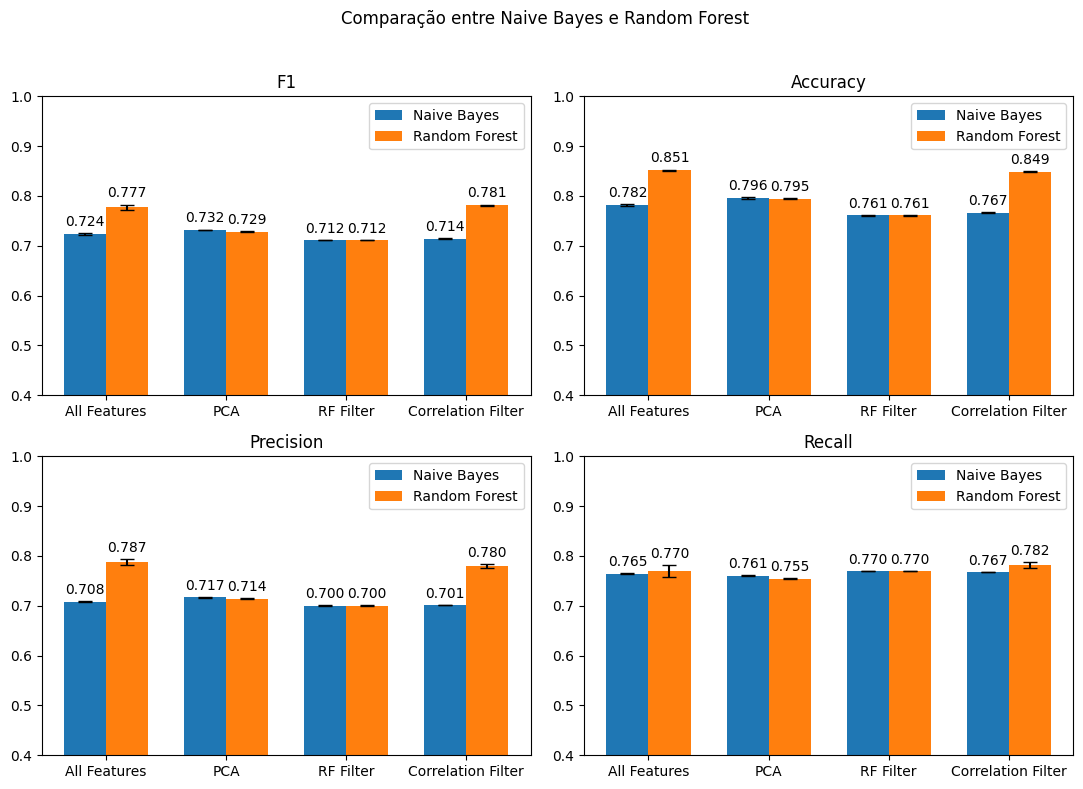

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Novos dados para Naive Bayes
data_all_features_bayes = {
    'f1': [0.726119, 0.725592, 0.724683, 0.722375, 0.722874, 0.722682, 0.722375, 0.722934, 0.722738, 0.723016],
    'accuracy': [0.786335, 0.785537, 0.784030, 0.779599, 0.780308, 0.779865, 0.779599, 0.779954, 0.779865, 0.780220],
    'precision': [0.710649, 0.710145, 0.709287, 0.707277, 0.707704, 0.707553, 0.707277, 0.707790, 0.707607, 0.707847],
    'recall': [0.762794, 0.762860, 0.763194, 0.765117, 0.765139, 0.765432, 0.765117, 0.765922, 0.765576, 0.765659]
}

data_pca_bayes = {
    'f1': [0.732789, 0.730902, 0.731559, 0.732407, 0.732860, 0.731385, 0.731249, 0.731013, 0.731946, 0.732835],
    'accuracy': [0.797501, 0.794045, 0.796172, 0.797235, 0.796881, 0.795108, 0.794842, 0.794222, 0.795374, 0.796792],
    'precision': [0.718004, 0.715667, 0.716736, 0.717659, 0.717848, 0.716296, 0.716126, 0.715792, 0.716767, 0.717803],
    'recall': [0.760136, 0.761385, 0.759428, 0.759677, 0.761327, 0.760768, 0.760886, 0.761354, 0.761660, 0.761414]
}

data_correlation_filter_bayes = {
    'f1': [0.714244, 0.714128, 0.713911, 0.714210, 0.715088, 0.714673, 0.714755, 0.714562, 0.714210, 0.714485],
    'accuracy': [0.766838, 0.766484, 0.766306, 0.766572, 0.767636, 0.767015, 0.767104, 0.766838, 0.766572, 0.766927],
    'precision': [0.701261, 0.701246, 0.701052, 0.701312, 0.701982, 0.701704, 0.701771, 0.701635, 0.701312, 0.701514],
    'recall': [0.766897, 0.767247, 0.766989, 0.767304, 0.767697, 0.767732, 0.767789, 0.767763, 0.767304, 0.767387]
}

data_rf_filter_bayes = {
    'f1': [0.711686, 0.711076, 0.710872, 0.711643, 0.712703, 0.711969, 0.711686, 0.711441, 0.711643, 0.712621],
    'accuracy': [0.761343, 0.760457, 0.760457, 0.761521, 0.762673, 0.761875, 0.761343, 0.761078, 0.761521, 0.762584],
    'precision': [0.700327, 0.699963, 0.699700, 0.700191, 0.701012, 0.700443, 0.700327, 0.700138, 0.700191, 0.700949],
    'recall': [0.770304, 0.770313, 0.769736, 0.769840, 0.770579, 0.770068, 0.770304, 0.770134, 0.769840, 0.770522]
}

# Dados para Random Forest
data_all_features_rf = {
    'f1': [0.768612, 0.767213, 0.771389, 0.780573, 0.781157, 0.780052, 0.779104, 0.778486, 0.783918, 0.780674],
    'accuracy': [0.852889, 0.852623, 0.853509, 0.850939, 0.851117, 0.850939, 0.849433, 0.849344, 0.852800, 0.851382],
    'precision': [0.795707, 0.796050, 0.795338, 0.783812, 0.783957, 0.784009, 0.781317, 0.781348, 0.786345, 0.784684],
    'recall': [0.750027, 0.747835, 0.754323, 0.777509, 0.778489, 0.776354, 0.776976, 0.775764, 0.781590, 0.776926]
}

data_pca_rf = {
    'f1': [0.727469, 0.727767, 0.727271, 0.728724, 0.728118, 0.728312, 0.730578, 0.728352, 0.729553, 0.728998],
    'accuracy': [0.794399, 0.794576, 0.793867, 0.795108, 0.794222, 0.794488, 0.796437, 0.794399, 0.795640, 0.795197],
    'precision': [0.713401, 0.713660, 0.713084, 0.714479, 0.713771, 0.713991, 0.716171, 0.713987, 0.715214, 0.714692],
    'recall': [0.752805, 0.753208, 0.753186, 0.754559, 0.754568, 0.754595, 0.756711, 0.754826, 0.755622, 0.755049]
}

data_correlation_filter_rf = {
    'f1': [0.777317, 0.777999, 0.781135, 0.781051, 0.782910, 0.782677, 0.781339, 0.782004, 0.780691, 0.782620],
    'accuracy': [0.851117, 0.850939, 0.852446, 0.847749, 0.848724, 0.848901, 0.847395, 0.847838, 0.847306, 0.848458],
    'precision': [0.785554, 0.784854, 0.786748, 0.777755, 0.779053, 0.779399, 0.777117, 0.777737, 0.777077, 0.778660],
    'recall': [0.770114, 0.771878, 0.776020, 0.784559, 0.787061, 0.786164, 0.785920, 0.786637, 0.784564, 0.786891]
}

# Função para calcular média e desvio padrão
def calculate_mean_std(data):
    return {
        'mean': np.mean(data),
        'std': np.std(data)
    }

# Armazenar resultados para Naive Bayes
results_bayes = {
    'All Features': {metric: calculate_mean_std(data_all_features_bayes[metric]) for metric in data_all_features_bayes},
    'PCA': {metric: calculate_mean_std(data_pca_bayes[metric]) for metric in data_pca_bayes},
    'RF Filter': {metric: calculate_mean_std(data_rf_filter_bayes[metric]) for metric in data_rf_filter_bayes},
    'Correlation Filter': {metric: calculate_mean_std(data_correlation_filter_bayes[metric]) for metric in data_correlation_filter_bayes}
}

# Armazenar resultados para Random Forest
results_rf = {
    'All Features': {metric: calculate_mean_std(data_all_features_rf[metric]) for metric in data_all_features_rf},
    'PCA': {metric: calculate_mean_std(data_pca_rf[metric]) for metric in data_pca_rf},
    'RF Filter': {metric: calculate_mean_std(data_rf_filter_bayes[metric]) for metric in data_rf_filter_bayes}, # using data from bayes as a workaround
    'Correlation Filter': {metric: calculate_mean_std(data_correlation_filter_rf[metric]) for metric in data_correlation_filter_rf}
}

# Criar os gráficos
metrics = ['f1', 'accuracy', 'precision', 'recall']
x = np.arange(len(results_bayes))  # Localização dos grupos
width = 0.35  # Largura das barras

fig, axs = plt.subplots(2, 2, figsize=(11, 8))
fig.suptitle('Comparação entre Naive Bayes e Random Forest')

# Iterar sobre as métricas e criar gráficos em subplots
for i, metric in enumerate(metrics):
    ax = axs[i//2, i%2]

    # Dados para Naive Bayes
    bayes_means = [results_bayes[model][metric]['mean'] for model in results_bayes]
    bayes_stds = [results_bayes[model][metric]['std'] for model in results_bayes]

    # Dados para Random Forest
    rf_means = [results_rf[model][metric]['mean'] for model in results_rf]
    rf_stds = [results_rf[model][metric]['std'] for model in results_rf]

    # Plot das barras para Naive Bayes
    rects1 = ax.bar(x - width/2, bayes_means, width, label='Naive Bayes', yerr=bayes_stds, capsize=5)

    # Plot das barras para Random Forest
    rects2 = ax.bar(x + width/2, rf_means, width, label='Random Forest', yerr=rf_stds, capsize=5)

    # Personalização dos subplots
    ax.set_title(metric.capitalize())
    ax.set_xticks(x)
    ax.set_xticklabels(results_bayes.keys())
    ax.legend(loc='upper right')
    ax.set_ylim(0.4, 1)
    ax.bar_label(rects1, fmt='%.3f', padding=3)
    ax.bar_label(rects2, fmt='%.3f', padding=3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()